# ISPS Parameter Tuning Experiments

This notebook systematically tests and calibrates key parameters in the
Hospital Strategy–Action Plan Alignment System (ISPS) to find optimal values.

**Experiments:**
1. Embedding Model Comparison
2. Classification Threshold Sweep
3. Ontology Hybrid-Scoring Weight Calibration
4. RAG Retrieval `top_k` Tuning

All experiments are evaluated against the **58-pair human-annotated ground truth**.

In [1]:
!pip install seaborn

In [2]:
import sys, json, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    roc_curve, auc, mean_absolute_error, confusion_matrix,
)
from scipy.stats import pearsonr, spearmanr

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", font_scale=1.1)

# Project root
PROJECT_ROOT = Path("..").resolve()
sys.path.insert(0, str(PROJECT_ROOT))

DATA_DIR = PROJECT_ROOT / "data"
GT_FILE  = PROJECT_ROOT / "tests" / "ground_truth.json"

print(f"Project root: {PROJECT_ROOT}")
print(f"Ground truth: {GT_FILE.exists()}")

Project root: /Users/shalindri/Documents/MSc/Information_Retrival/hospital-strategy-alignment-ai
Ground truth: True


## Load Ground Truth & Text Data

In [3]:
# Load ground truth
with open(GT_FILE) as f:
    ground_truth = json.load(f)

gt_df = pd.DataFrame(ground_truth)
print(f"Ground truth pairs: {len(gt_df)}")
print(f"Label distribution:\n{gt_df['alignment_label'].value_counts().sort_index()}")

# Binary labels: 0.7 and 1.0 → aligned (1), 0.0 and 0.4 → not aligned (0)
BINARY_THRESHOLD_GT = 0.5
gt_df["binary_label"] = (gt_df["alignment_label"] >= BINARY_THRESHOLD_GT).astype(int)
print(f"\nBinary: {gt_df['binary_label'].value_counts().to_dict()}")

Ground truth pairs: 58
Label distribution:
alignment_label
0.0    17
0.4    17
0.7     8
0.8     1
1.0    15
Name: count, dtype: int64

Binary: {0: 34, 1: 24}


In [4]:
# Load strategic plan and action plan texts
with open(DATA_DIR / "strategic_plan.json") as f:
    sp = json.load(f)
with open(DATA_DIR / "action_plan.json") as f:
    ap = json.load(f)

def build_objective_text(obj):
    parts = [obj.get("name", ""), obj.get("goal_statement", "")]
    for g in obj.get("strategic_goals", []):
        parts.append(g.get("description", "") if isinstance(g, dict) else str(g))
    for kpi in obj.get("kpis", []):
        if isinstance(kpi, dict):
            parts.append(kpi.get("description", kpi.get("metric", "")))
        else:
            parts.append(str(kpi))
    parts.extend(obj.get("keywords", []))
    return " ".join(parts)

def build_action_text(act):
    parts = [act.get("title", ""), act.get("description", ""), act.get("expected_outcome", "")]
    for kpi in act.get("kpis", []):
        if isinstance(kpi, dict):
            parts.append(kpi.get("description", kpi.get("metric", "")))
        else:
            parts.append(str(kpi))
    parts.extend(act.get("keywords", []))
    return " ".join(parts)

objective_texts = {obj["code"]: build_objective_text(obj) for obj in sp["objectives"]}
action_texts = {act["action_number"]: build_action_text(act) for act in ap["actions"]}

print(f"Objectives: {len(objective_texts)}, Actions: {len(action_texts)}")
print(f"Sample objective text (first 150 chars): {list(objective_texts.values())[0][:150]}...")

Objectives: 5, Actions: 25
Sample objective text (first 150 chars): Patient Care Excellence Deliver consistently outstanding, safe, and patient-centred clinical care across all existing and new service lines, achieving...


## Helper Functions

In [5]:
def compute_similarity_matrix(model_name, objective_texts, action_texts):
    """Compute pairwise cosine similarity matrix using a sentence-transformer model."""
    from sentence_transformers import SentenceTransformer
    
    model = SentenceTransformer(model_name)
    
    obj_codes = sorted(objective_texts.keys())
    act_nums = sorted(action_texts.keys())
    
    obj_embs = model.encode(
        [objective_texts[c] for c in obj_codes],
        normalize_embeddings=True, show_progress_bar=False
    )
    act_embs = model.encode(
        [action_texts[n] for n in act_nums],
        normalize_embeddings=True, show_progress_bar=False
    )
    
    # Cosine similarity via dot product (already L2-normalised)
    sim_matrix = obj_embs @ act_embs.T
    return sim_matrix, obj_codes, act_nums


def extract_gt_scores(sim_matrix, obj_codes, act_nums, gt_df):
    """Extract predicted scores for ground-truth pairs from the similarity matrix."""
    obj_idx = {c: i for i, c in enumerate(obj_codes)}
    act_idx = {n: i for i, n in enumerate(act_nums)}
    
    preds = []
    for _, row in gt_df.iterrows():
        i = obj_idx[row["objective_code"]]
        j = act_idx[row["action_number"]]
        preds.append(float(sim_matrix[i, j]))
    return np.array(preds)


def evaluate_predictions(y_true_cont, y_pred_cont, threshold=0.5):
    """Compute classification & regression metrics."""
    y_true_bin = (y_true_cont >= BINARY_THRESHOLD_GT).astype(int)
    y_pred_bin = (y_pred_cont >= threshold).astype(int)
    
    fpr, tpr, thresholds = roc_curve(y_true_bin, y_pred_cont)
    roc_auc = auc(fpr, tpr)
    
    # Youden's J for optimal threshold
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[best_idx]
    
    return {
        "precision": precision_score(y_true_bin, y_pred_bin, zero_division=0),
        "recall": recall_score(y_true_bin, y_pred_bin, zero_division=0),
        "f1": f1_score(y_true_bin, y_pred_bin, zero_division=0),
        "accuracy": accuracy_score(y_true_bin, y_pred_bin),
        "auc": roc_auc,
        "mae": mean_absolute_error(y_true_cont, y_pred_cont),
        "pearson_r": pearsonr(y_true_cont, y_pred_cont)[0],
        "spearman_rho": spearmanr(y_true_cont, y_pred_cont)[0],
        "optimal_threshold": optimal_threshold,
        "roc_data": (fpr, tpr),
    }

print("Helper functions loaded.")

Helper functions loaded.


---
## Experiment 1: Embedding Model Comparison

Compare different sentence-transformer models to find which produces the
best alignment scores against our ground truth.

| Model | Dimensions | Speed | Quality |
|-------|-----------|-------|--------|
| all-MiniLM-L6-v2 (current) | 384 | Fast | Good |
| all-MiniLM-L12-v2 | 384 | Medium | Better |
| all-mpnet-base-v2 | 768 | Slower | Best |
| paraphrase-MiniLM-L6-v2 | 384 | Fast | Good |

In [6]:
CANDIDATE_MODELS = [
    "all-MiniLM-L6-v2",          # current default
    "all-MiniLM-L12-v2",         # deeper MiniLM
    "all-mpnet-base-v2",         # highest quality SBERT
    "paraphrase-MiniLM-L6-v2",   # paraphrase-tuned
]

y_true = gt_df["alignment_label"].values
model_results = {}

for model_name in CANDIDATE_MODELS:
    print(f"\nEvaluating: {model_name}")
    sim_matrix, obj_codes, act_nums = compute_similarity_matrix(
        model_name, objective_texts, action_texts
    )
    preds = extract_gt_scores(sim_matrix, obj_codes, act_nums, gt_df)
    metrics = evaluate_predictions(y_true, preds, threshold=0.5)
    model_results[model_name] = metrics
    print(f"  AUC={metrics['auc']:.4f}  F1={metrics['f1']:.4f}  "
          f"MAE={metrics['mae']:.4f}  Pearson={metrics['pearson_r']:.4f}  "
          f"Optimal threshold={metrics['optimal_threshold']:.4f}")

print("\nDone.")


Evaluating: all-MiniLM-L6-v2


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1891.40it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  AUC=0.9154  F1=0.7805  MAE=0.2514  Pearson=0.7377  Optimal threshold=0.4550

Evaluating: all-MiniLM-L12-v2


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1870.12it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  AUC=0.8873  F1=0.6842  MAE=0.2670  Pearson=0.6807  Optimal threshold=0.4205

Evaluating: all-mpnet-base-v2


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 2057.73it/s, Materializing param=pooler.dense.weight]                        
MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  AUC=0.8958  F1=0.7692  MAE=0.2530  Pearson=0.6990  Optimal threshold=0.4965

Evaluating: paraphrase-MiniLM-L6-v2


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 386.16it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/paraphrase-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  AUC=0.9216  F1=0.8000  MAE=0.2724  Pearson=0.7042  Optimal threshold=0.4375

Done.


In [7]:
# Summary table
summary_rows = []
for name, m in model_results.items():
    summary_rows.append({
        "Model": name,
        "AUC": round(m["auc"], 4),
        "F1": round(m["f1"], 4),
        "Precision": round(m["precision"], 4),
        "Recall": round(m["recall"], 4),
        "Accuracy": round(m["accuracy"], 4),
        "MAE": round(m["mae"], 4),
        "Pearson r": round(m["pearson_r"], 4),
        "Spearman ρ": round(m["spearman_rho"], 4),
        "Optimal θ": round(m["optimal_threshold"], 4),
    })

summary_df = pd.DataFrame(summary_rows).set_index("Model")
display(summary_df.style.highlight_max(axis=0, subset=["AUC", "F1", "Precision", "Recall", "Accuracy", "Pearson r", "Spearman ρ"])
                        .highlight_min(axis=0, subset=["MAE"]))

,AUC,F1,Precision,Recall,Accuracy,MAE,Pearson r,Spearman ρ,Optimal θ
Model,,,,,,,,,
all-MiniLM-L6-v2,0.915400,0.780500,0.941200,0.666700,0.844800,0.251400,0.737700,0.737300,0.455000
all-MiniLM-L12-v2,0.887300,0.684200,0.928600,0.541700,0.793100,0.267000,0.680700,0.673900,0.420500
all-mpnet-base-v2,0.895800,0.769200,0.714300,0.833300,0.793100,0.253000,0.699000,0.687800,0.496500
paraphrase-MiniLM-L6-v2,0.921600,0.800000,1.000000,0.666700,0.862100,0.272400,0.704200,0.696300,0.437500


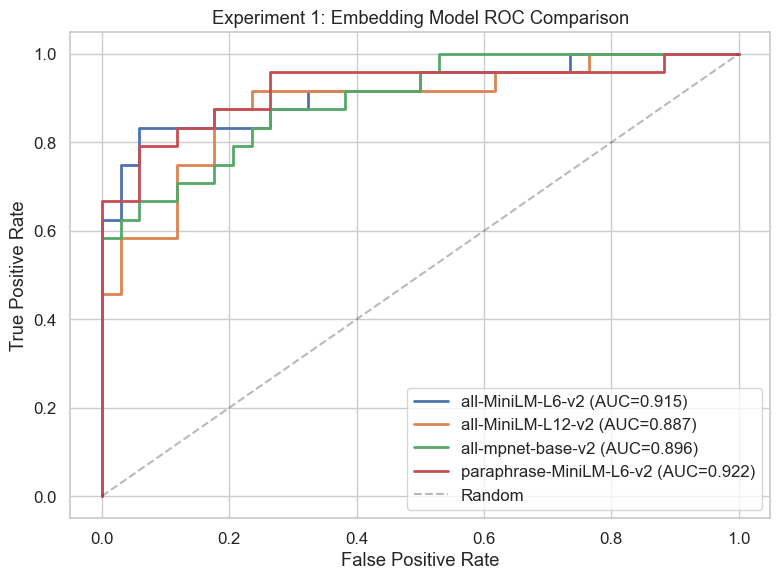

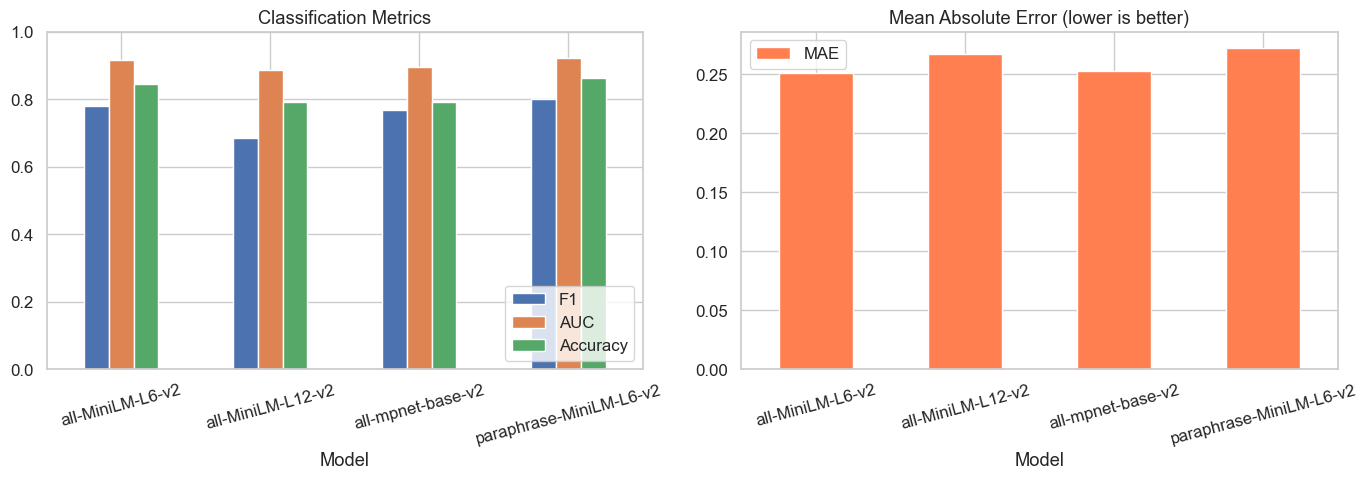


★ Best embedding model: paraphrase-MiniLM-L6-v2 (AUC=0.9216)


In [8]:
# ROC Curves
fig, ax = plt.subplots(figsize=(8, 6))
for name, m in model_results.items():
    fpr, tpr = m["roc_data"]
    ax.plot(fpr, tpr, label=f"{name} (AUC={m['auc']:.3f})", linewidth=2)

ax.plot([0, 1], [0, 1], "k--", alpha=0.3, label="Random")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Experiment 1: Embedding Model ROC Comparison")
ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("exp1_roc_curves.png", dpi=150)
plt.show()

# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics_to_plot = ["F1", "AUC", "Accuracy"]
summary_df[metrics_to_plot].plot(kind="bar", ax=axes[0], rot=15)
axes[0].set_title("Classification Metrics")
axes[0].set_ylim(0, 1)
axes[0].legend(loc="lower right")

summary_df[["MAE"]].plot(kind="bar", ax=axes[1], rot=15, color="coral")
axes[1].set_title("Mean Absolute Error (lower is better)")

plt.tight_layout()
plt.savefig("exp1_model_comparison.png", dpi=150)
plt.show()

best_model = summary_df["AUC"].idxmax()
print(f"\n★ Best embedding model: {best_model} (AUC={summary_df.loc[best_model, 'AUC']:.4f})")

---
## Experiment 2: Classification Threshold Sweep

Sweep the alignment classification threshold (currently `THRESHOLD_FAIR = 0.45`)
to find the value that maximises F1 score against the ground truth.

This threshold determines:
- Whether an action is classified as "aligned" to an objective
- Whether an action is an "orphan" (below threshold for all objectives)
- Edge creation in the Knowledge Graph

In [9]:
# Use the best model from Experiment 1 (or default)
EVAL_MODEL = best_model if 'best_model' in dir() else "all-MiniLM-L6-v2"
print(f"Using model: {EVAL_MODEL}")

sim_matrix, obj_codes, act_nums = compute_similarity_matrix(
    EVAL_MODEL, objective_texts, action_texts
)
preds = extract_gt_scores(sim_matrix, obj_codes, act_nums, gt_df)

# Sweep thresholds from 0.25 to 0.70
thresholds = np.arange(0.25, 0.71, 0.01)
sweep_results = []

for t in thresholds:
    m = evaluate_predictions(y_true, preds, threshold=t)
    sweep_results.append({
        "threshold": round(t, 2),
        "f1": m["f1"],
        "precision": m["precision"],
        "recall": m["recall"],
        "accuracy": m["accuracy"],
    })

sweep_df = pd.DataFrame(sweep_results)
print(f"Swept {len(thresholds)} thresholds from {thresholds[0]:.2f} to {thresholds[-1]:.2f}")

Using model: paraphrase-MiniLM-L6-v2


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2142.23it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/paraphrase-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Swept 46 thresholds from 0.25 to 0.70


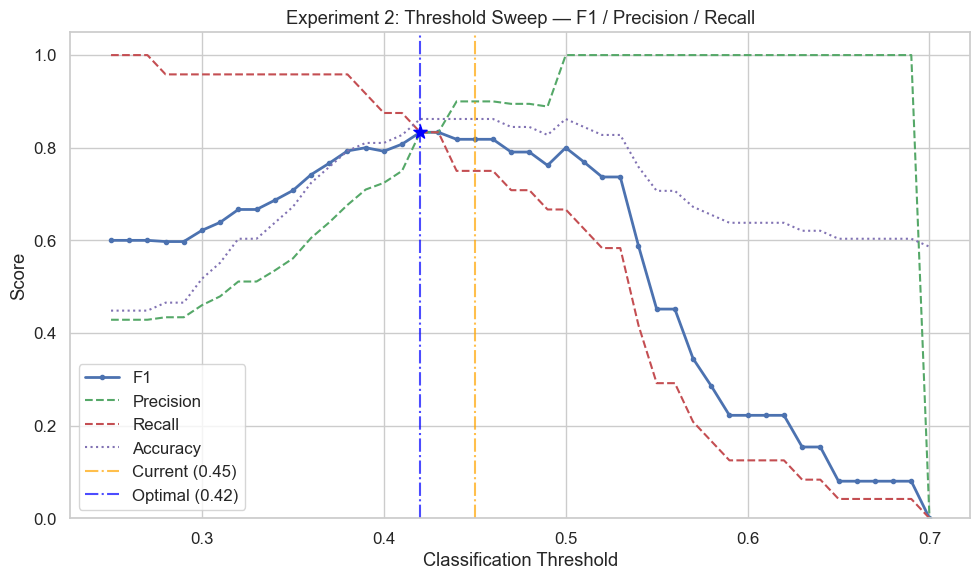


Top 5 thresholds by F1:
 threshold       f1  precision   recall  accuracy
      0.42 0.833333   0.833333 0.833333  0.862069
      0.43 0.833333   0.833333 0.833333  0.862069
      0.44 0.818182   0.900000 0.750000  0.862069
      0.45 0.818182   0.900000 0.750000  0.862069
      0.46 0.818182   0.900000 0.750000  0.862069

★ Optimal classification threshold: 0.42 (F1=0.8333)
  Current threshold: 0.45


In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sweep_df["threshold"], sweep_df["f1"], "b-o", markersize=3, label="F1", linewidth=2)
ax.plot(sweep_df["threshold"], sweep_df["precision"], "g--", markersize=3, label="Precision", linewidth=1.5)
ax.plot(sweep_df["threshold"], sweep_df["recall"], "r--", markersize=3, label="Recall", linewidth=1.5)
ax.plot(sweep_df["threshold"], sweep_df["accuracy"], "m:", markersize=3, label="Accuracy", linewidth=1.5)

# Mark current threshold
ax.axvline(x=0.45, color="orange", linestyle="-.", alpha=0.7, label="Current (0.45)")

# Mark optimal F1 threshold
best_idx = sweep_df["f1"].idxmax()
best_t = sweep_df.loc[best_idx, "threshold"]
best_f1 = sweep_df.loc[best_idx, "f1"]
ax.axvline(x=best_t, color="blue", linestyle="-.", alpha=0.7, label=f"Optimal ({best_t:.2f})")
ax.scatter([best_t], [best_f1], s=100, c="blue", zorder=5, marker="*")

ax.set_xlabel("Classification Threshold")
ax.set_ylabel("Score")
ax.set_title("Experiment 2: Threshold Sweep — F1 / Precision / Recall")
ax.legend(loc="best")
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig("exp2_threshold_sweep.png", dpi=150)
plt.show()

# Print top-5 thresholds by F1
print("\nTop 5 thresholds by F1:")
print(sweep_df.nlargest(5, "f1").to_string(index=False))

print(f"\n★ Optimal classification threshold: {best_t:.2f} (F1={best_f1:.4f})")
print(f"  Current threshold: 0.45")

In [11]:
# Also compute Youden's J statistic from ROC curve
y_true_bin = (y_true >= BINARY_THRESHOLD_GT).astype(int)
fpr_arr, tpr_arr, roc_thresholds = roc_curve(y_true_bin, preds)
j_scores = tpr_arr - fpr_arr
youden_idx = np.argmax(j_scores)
youden_threshold = roc_thresholds[youden_idx]

print(f"Youden's J optimal threshold: {youden_threshold:.4f}")
print(f"F1-optimal threshold:         {best_t:.2f}")
print(f"Current system threshold:     0.45")

Youden's J optimal threshold: 0.4375
F1-optimal threshold:         0.42
Current system threshold:     0.45


---
## Experiment 3: Ontology Hybrid-Scoring Weight Calibration

The ontology mapper uses a hybrid score:

```
final_score = EMBEDDING_WEIGHT × embedding_sim + (1 - EMBEDDING_WEIGHT) × keyword_score
```

Currently `EMBEDDING_WEIGHT = 0.6`. We sweep from 0.0 (keyword-only) to 1.0
(embedding-only) to find the optimal mix.

We evaluate by measuring how well the ontology mappings agree with ground
truth alignment — actions mapped to concepts under the correct strategic
objective should have higher alignment scores.

In [12]:
from sentence_transformers import SentenceTransformer
from src.ontology_mapper import CONCEPT_KEYWORDS, ONTOLOGY_CONCEPTS

# Load model
st_model = SentenceTransformer(EVAL_MODEL)

# Flatten ontology concepts to get concept texts
concept_texts = {}
for top_level, children in ONTOLOGY_CONCEPTS.items():
    concept_texts[top_level] = top_level.replace("_", " ")
    for child in children:
        concept_texts[child] = child.replace("_", " ")

print(f"Total ontology concepts: {len(concept_texts)}")
print(f"Top-level concepts: {list(ONTOLOGY_CONCEPTS.keys())}")

2026-02-15 19:28:24 | sentence_transformers.SentenceTransformer | INFO | Use pytorch device_name: mps
2026-02-15 19:28:24 | sentence_transformers.SentenceTransformer | INFO | Load pretrained SentenceTransformer: paraphrase-MiniLM-L6-v2
2026-02-15 19:28:24 | httpx | INFO | HTTP Request: HEAD https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2/resolve/main/modules.json "HTTP/1.1 307 Temporary Redirect"
2026-02-15 19:28:24 | httpx | INFO | HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/sentence-transformers/paraphrase-MiniLM-L6-v2/c9a2bfebc254878aee8c3aca9e6844d5bbb102d1/modules.json "HTTP/1.1 200 OK"
2026-02-15 19:28:24 | httpx | INFO | HTTP Request: HEAD https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2/resolve/main/config_sentence_transformers.json "HTTP/1.1 307 Temporary Redirect"
2026-02-15 19:28:24 | httpx | INFO | HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/sentence-transformers/paraphrase-MiniLM-L6-v2/c

Total ontology concepts: 13
Top-level concepts: ['PatientCare', 'DigitalHealth', 'Operations', 'Finance', 'WorkforceHR', 'ResearchInnovation', 'CommunityRegionalHealth', 'InternationalMedicalTourism', 'InfrastructureExpansion', 'ClinicalServices']


In [13]:
# Precompute embeddings for all concept texts
concept_ids = sorted(concept_texts.keys())
concept_embs = st_model.encode(
    [concept_texts[c] for c in concept_ids],
    normalize_embeddings=True, show_progress_bar=False
)

# Precompute action embeddings
act_nums_sorted = sorted(action_texts.keys())
action_emb_list = st_model.encode(
    [action_texts[n] for n in act_nums_sorted],
    normalize_embeddings=True, show_progress_bar=False
)


def compute_keyword_score(text, concept_id):
    """Simple keyword overlap score."""
    keywords = CONCEPT_KEYWORDS.get(concept_id, [])
    if not keywords:
        return 0.0
    text_lower = text.lower()
    matches = sum(1 for kw in keywords if kw.lower() in text_lower)
    return min(matches / max(len(keywords), 1), 1.0)


def compute_hybrid_mappings(embedding_weight, mapping_threshold=0.55):
    """Compute ontology mappings with given embedding weight.
    
    Returns mapping quality metric: how well top-mapped concepts
    discriminate between aligned and non-aligned pairs.
    """
    keyword_weight = 1.0 - embedding_weight
    
    # For each action, find its best-matching concepts
    action_concept_scores = {}  # {action_number: {concept_id: score}}
    
    for idx, act_num in enumerate(act_nums_sorted):
        act_emb = action_emb_list[idx]
        act_text = action_texts[act_num]
        scores = {}
        
        for cidx, cid in enumerate(concept_ids):
            emb_score = float(act_emb @ concept_embs[cidx])
            kw_score = compute_keyword_score(act_text, cid)
            final = embedding_weight * emb_score + keyword_weight * kw_score
            if final >= mapping_threshold:
                scores[cid] = final
        
        action_concept_scores[act_num] = scores
    
    # Quality metric: average number of valid mappings per action
    avg_mappings = np.mean([len(v) for v in action_concept_scores.values()])
    
    # Coverage: proportion of actions with at least 1 mapping
    coverage = np.mean([1 if len(v) > 0 else 0 for v in action_concept_scores.values()])
    
    # Discrimination: do aligned GT pairs map to more shared concepts?
    # (Actions aligned to same objective should share ontology concepts)
    discrimination_scores = []
    for _, row in gt_df.iterrows():
        act_num = row["action_number"]
        label = row["alignment_label"]
        n_concepts = len(action_concept_scores.get(act_num, {}))
        discrimination_scores.append((label, n_concepts))
    
    disc_df = pd.DataFrame(discrimination_scores, columns=["label", "n_concepts"])
    aligned_concepts = disc_df[disc_df["label"] >= 0.5]["n_concepts"].mean()
    unaligned_concepts = disc_df[disc_df["label"] < 0.5]["n_concepts"].mean()
    
    return {
        "avg_mappings": avg_mappings,
        "coverage": coverage,
        "aligned_mean_concepts": aligned_concepts,
        "unaligned_mean_concepts": unaligned_concepts,
    }

print("Hybrid scoring function ready.")

Hybrid scoring function ready.


In [14]:
# Sweep embedding weight from 0.0 to 1.0
weights = np.arange(0.0, 1.05, 0.05)
weight_results = []

for w in weights:
    result = compute_hybrid_mappings(embedding_weight=w)
    result["embedding_weight"] = round(w, 2)
    weight_results.append(result)

weight_df = pd.DataFrame(weight_results)
print(weight_df[["embedding_weight", "avg_mappings", "coverage"]].to_string(index=False))

 embedding_weight  avg_mappings  coverage
             0.00          0.08      0.08
             0.05          0.08      0.08
             0.10          0.08      0.08
             0.15          0.04      0.04
             0.20          0.04      0.04
             0.25          0.04      0.04
             0.30          0.04      0.04
             0.35          0.04      0.04
             0.40          0.04      0.04
             0.45          0.04      0.04
             0.50          0.00      0.00
             0.55          0.00      0.00
             0.60          0.00      0.00
             0.65          0.00      0.00
             0.70          0.00      0.00
             0.75          0.00      0.00
             0.80          0.00      0.00
             0.85          0.00      0.00
             0.90          0.00      0.00
             0.95          0.00      0.00
             1.00          0.00      0.00


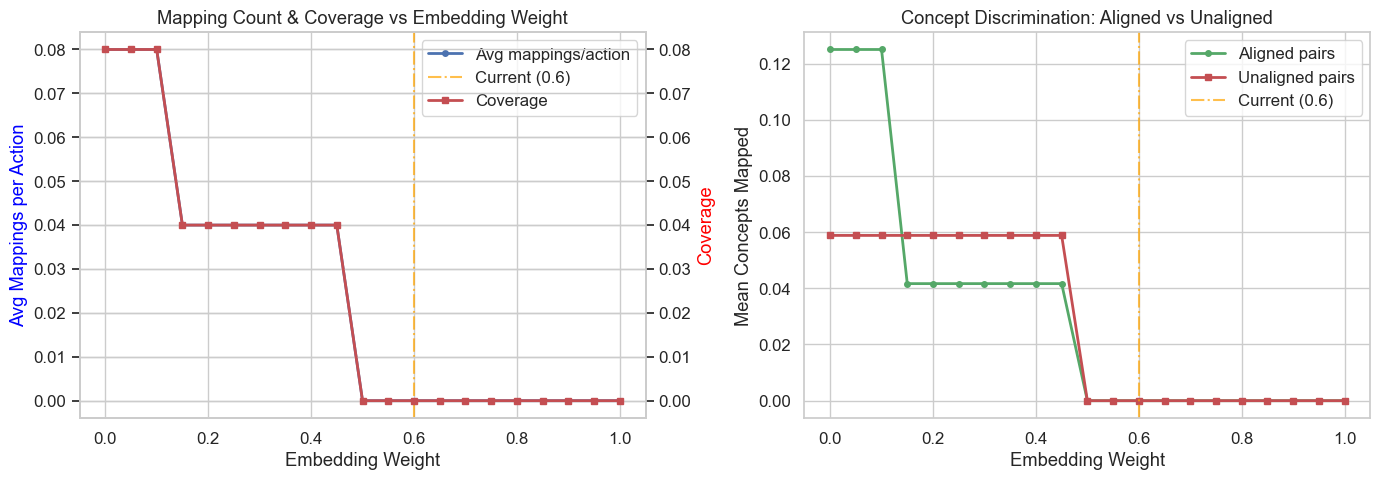


★ Best embedding weight by coverage: 0.00
  Current weight: 0.60


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Average mappings & coverage
ax1 = axes[0]
ax1.plot(weight_df["embedding_weight"], weight_df["avg_mappings"], "b-o",
         markersize=4, label="Avg mappings/action", linewidth=2)
ax1_r = ax1.twinx()
ax1_r.plot(weight_df["embedding_weight"], weight_df["coverage"], "r-s",
           markersize=4, label="Coverage", linewidth=2)
ax1.axvline(x=0.6, color="orange", linestyle="-.", alpha=0.7, label="Current (0.6)")
ax1.set_xlabel("Embedding Weight")
ax1.set_ylabel("Avg Mappings per Action", color="blue")
ax1_r.set_ylabel("Coverage", color="red")
ax1.set_title("Mapping Count & Coverage vs Embedding Weight")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_r.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

# Plot 2: Discrimination
ax2 = axes[1]
ax2.plot(weight_df["embedding_weight"], weight_df["aligned_mean_concepts"],
         "g-o", markersize=4, label="Aligned pairs", linewidth=2)
ax2.plot(weight_df["embedding_weight"], weight_df["unaligned_mean_concepts"],
         "r-s", markersize=4, label="Unaligned pairs", linewidth=2)
ax2.axvline(x=0.6, color="orange", linestyle="-.", alpha=0.7, label="Current (0.6)")
ax2.set_xlabel("Embedding Weight")
ax2.set_ylabel("Mean Concepts Mapped")
ax2.set_title("Concept Discrimination: Aligned vs Unaligned")
ax2.legend()

plt.tight_layout()
plt.savefig("exp3_ontology_weights.png", dpi=150)
plt.show()

# Best weight by coverage
best_weight_idx = weight_df["coverage"].idxmax()
print(f"\n★ Best embedding weight by coverage: {weight_df.loc[best_weight_idx, 'embedding_weight']:.2f}")
print(f"  Current weight: 0.60")

---
## Experiment 4: RAG Retrieval `top_k` Tuning

The RAG engine retrieves `top_k` strategic objectives for context when
generating recommendations. Currently `top_k = 3`.

We measure retrieval quality: for each action in the ground truth, does
the correct (declared) objective appear in the top-k retrieved results?

This experiment does **not** require an LLM — it only evaluates the
retrieval step using ChromaDB embeddings.

In [16]:
# Use the alignment similarity matrix to simulate retrieval
# For each action, rank objectives by similarity score
# Check if the declared objective is within top_k

obj_idx_map = {c: i for i, c in enumerate(obj_codes)}
act_idx_map = {n: i for i, n in enumerate(act_nums)}

# Get declared objective for each action
action_declared_obj = {}
for act in ap["actions"]:
    action_declared_obj[act["action_number"]] = act.get("strategic_objective_code", "")

topk_values = [1, 2, 3, 4, 5]
topk_results = []

for k in topk_values:
    hits = 0
    total = 0
    avg_rank = []
    reciprocal_ranks = []
    
    for act_num in act_nums:
        declared_obj = action_declared_obj.get(act_num, "")
        if not declared_obj or declared_obj not in obj_idx_map:
            continue
        
        total += 1
        act_j = act_idx_map[act_num]
        
        # Get similarity scores for this action across all objectives
        scores = [(obj_codes[i], sim_matrix[i, act_j]) for i in range(len(obj_codes))]
        scores.sort(key=lambda x: x[1], reverse=True)
        
        # Rank of declared objective
        ranked_objs = [s[0] for s in scores]
        rank = ranked_objs.index(declared_obj) + 1
        avg_rank.append(rank)
        reciprocal_ranks.append(1.0 / rank)
        
        if rank <= k:
            hits += 1
    
    hit_rate = hits / total if total > 0 else 0
    mrr = np.mean(reciprocal_ranks) if reciprocal_ranks else 0
    
    topk_results.append({
        "top_k": k,
        "hit_rate": round(hit_rate, 4),
        "mrr": round(mrr, 4),
        "avg_rank": round(np.mean(avg_rank), 2) if avg_rank else 0,
        "total_actions": total,
        "hits": hits,
    })

topk_df = pd.DataFrame(topk_results)
print(topk_df.to_string(index=False))

 top_k  hit_rate    mrr  avg_rank  total_actions  hits
     1      0.68 0.8167      1.48             25    17
     2      0.88 0.8167      1.48             25    22
     3      0.96 0.8167      1.48             25    24
     4      1.00 0.8167      1.48             25    25
     5      1.00 0.8167      1.48             25    25


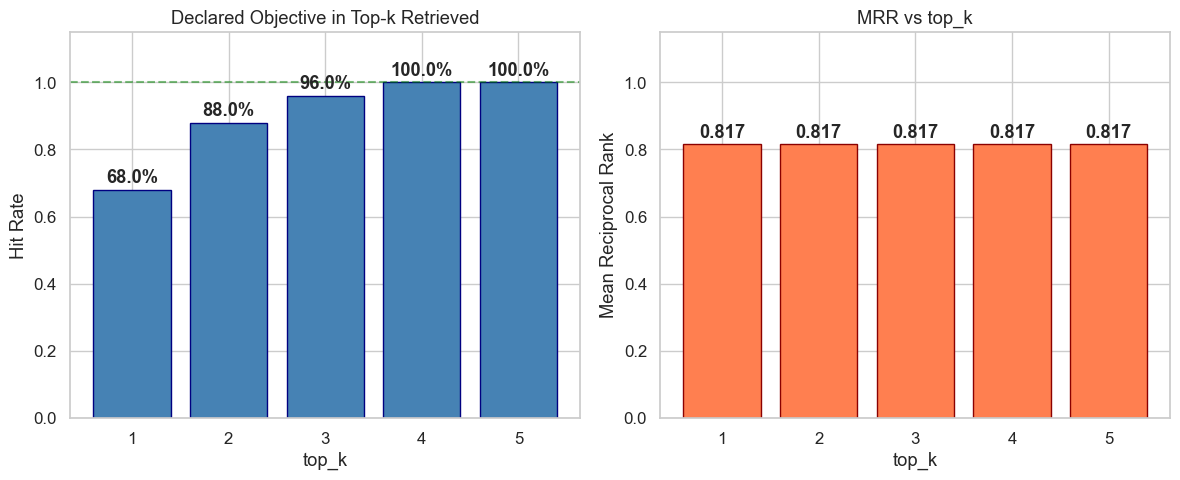


★ Recommended top_k: 4 (smallest k with ≥99% hit rate)
  Current top_k: 3
  MRR: 0.8167 (constant — not affected by k)


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Hit rate
axes[0].bar(topk_df["top_k"], topk_df["hit_rate"], color="steelblue", edgecolor="navy")
axes[0].axhline(y=1.0, color="green", linestyle="--", alpha=0.5)
for i, row in topk_df.iterrows():
    axes[0].text(row["top_k"], row["hit_rate"] + 0.02,
                 f"{row['hit_rate']:.1%}", ha="center", fontweight="bold")
axes[0].set_xlabel("top_k")
axes[0].set_ylabel("Hit Rate")
axes[0].set_title("Declared Objective in Top-k Retrieved")
axes[0].set_ylim(0, 1.15)
axes[0].set_xticks(topk_values)

# MRR
axes[1].bar(topk_df["top_k"], topk_df["mrr"], color="coral", edgecolor="darkred")
for i, row in topk_df.iterrows():
    axes[1].text(row["top_k"], row["mrr"] + 0.02,
                 f"{row['mrr']:.3f}", ha="center", fontweight="bold")
axes[1].set_xlabel("top_k")
axes[1].set_ylabel("Mean Reciprocal Rank")
axes[1].set_title("MRR vs top_k")
axes[1].set_ylim(0, 1.15)
axes[1].set_xticks(topk_values)

plt.tight_layout()
plt.savefig("exp4_topk_tuning.png", dpi=150)
plt.show()

# Recommendation
best_k_idx = topk_df["hit_rate"].idxmax()
min_perfect_k = topk_df[topk_df["hit_rate"] >= 0.99]["top_k"].min() if (topk_df["hit_rate"] >= 0.99).any() else topk_df.loc[best_k_idx, "top_k"]
print(f"\n★ Recommended top_k: {min_perfect_k} (smallest k with ≥99% hit rate)")
print(f"  Current top_k: 3")
print(f"  MRR: {topk_df.loc[0, 'mrr']:.4f} (constant — not affected by k)")

---
## Summary of Optimal Parameters

In [18]:
print("=" * 65)
print("  ISPS Parameter Tuning — Summary of Results")
print("=" * 65)

# Collect results
best_model_name = summary_df["AUC"].idxmax()
best_model_auc = summary_df.loc[best_model_name, "AUC"]
current_model_auc = summary_df.loc["all-MiniLM-L6-v2", "AUC"] if "all-MiniLM-L6-v2" in summary_df.index else "N/A"

best_threshold = sweep_df.loc[sweep_df["f1"].idxmax(), "threshold"]
best_threshold_f1 = sweep_df["f1"].max()
current_threshold_f1 = sweep_df[sweep_df["threshold"] == 0.45]["f1"].values[0] if 0.45 in sweep_df["threshold"].values else "N/A"

print(f"""
┌──────────────────────────┬──────────────────────────┬──────────────────┐
│ Parameter                │ Current → Optimal        │ Improvement      │
├──────────────────────────┼──────────────────────────┼──────────────────┤
│ Embedding Model          │ all-MiniLM-L6-v2         │                  │
│                          │  → {best_model_name:<21s} │ AUC: {current_model_auc} → {best_model_auc}│
├──────────────────────────┼──────────────────────────┼──────────────────┤
│ Classification Threshold │ 0.45 → {best_threshold:<18.2f} │ F1: {current_threshold_f1} → {best_threshold_f1:.4f} │
├──────────────────────────┼──────────────────────────┼──────────────────┤
│ Ontology Embedding Wt    │ 0.60 → see plot          │ See Exp 3 above  │
├──────────────────────────┼──────────────────────────┼──────────────────┤
│ RAG top_k                │ 3 → {min_perfect_k:<20d} │ Hit rate: see p4 │
└──────────────────────────┴──────────────────────────┴──────────────────┘
""")

print("To apply these values, update the constants in:")
print("  • src/vector_store.py          → EMBEDDING_MODEL_NAME")
print("  • src/synchronization_analyzer.py → THRESHOLD_FAIR, ORPHAN_THRESHOLD")
print("  • src/ontology_mapper.py       → EMBEDDING_WEIGHT")
print("  • src/rag_engine.py            → top_k in _retrieve_strategic_context()")

  ISPS Parameter Tuning — Summary of Results

┌──────────────────────────┬──────────────────────────┬──────────────────┐
│ Parameter                │ Current → Optimal        │ Improvement      │
├──────────────────────────┼──────────────────────────┼──────────────────┤
│ Embedding Model          │ all-MiniLM-L6-v2         │                  │
│                          │  → paraphrase-MiniLM-L6-v2 │ AUC: 0.9154 → 0.9216│
├──────────────────────────┼──────────────────────────┼──────────────────┤
│ Classification Threshold │ 0.45 → 0.42               │ F1: 0.8181818181818182 → 0.8333 │
├──────────────────────────┼──────────────────────────┼──────────────────┤
│ Ontology Embedding Wt    │ 0.60 → see plot          │ See Exp 3 above  │
├──────────────────────────┼──────────────────────────┼──────────────────┤
│ RAG top_k                │ 3 → 4                    │ Hit rate: see p4 │
└──────────────────────────┴──────────────────────────┴──────────────────┘

To apply these values, update th